<img src="images/seattle.jpg">

# King County House Sales Analysis
Author: Jennifer Ha
***

## Overview placeholder
This analysis project explores trends in film business to provide Microsoft with actionable recommendations as they want to enter this business as well. we will review data sets from TheNumbers.com and IMDb to determine when Microsoft should release a movie, which types of genres to consider, and whom to recruit. The methodology includes filtering, and joining and visualizing data sets to show different trends in ROI. The result shows higher ROI when Mystery, Horror, and Animation movies are released in May-July, and November-December. I recommend Microsoft to partner with lists of top 10 actors and directors in those genres, and release movies during the summer (May-July) or holiday season (Nov-Dec).

## Business Problem placeholder
Microsoft sees all the big companies creating original video content and they want to get in on the fun. They have decided to create a new movie studio, but they don’t know anything about creating movies.

In order to assist the stakeholders at Microsoft to make data-driven decisions for their new business, we will be reviewing and analyzing datasets to provide a viable and profitable business option. The findings and recommendations will help the stakeholders with better understanding of the movie industry, to decide when to release their movies and who to work with to drive a successful outcome.

나는 부동산 업체의 입장에서 어떠한 집들을 매물로 준비해야 더 이익을 볼 수 있는지 언제 deal을 close 하는게 좋을지

## Data

### Data Preparation & Clean Up

In [1]:
# Import all libraries & packages
import numpy as np
import pandas as pd
from pandas.plotting import table
import matplotlib.pyplot as plt
import matplotlib.colors as pltcol
import seaborn as sns
import math

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tools.eval_measures as ev
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error, make_scorer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from scipy.special import boxcox, inv_boxcox
from matplotlib.gridspec import GridSpec

import scipy.stats as stats
from statsmodels.formula.api import ols

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

%matplotlib inline

# Import my personal functions 
from functions import model_summary,linear_model

# Remove scientific notation
pd.options.display.float_format = '{:,.5f}'.format

# Display all the columns without truncation
pd.set_option('display.max_columns', None)

# Import data into a dataframe and preview 
df = pd.read_csv('data/kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,"221,900.00000",3,1.00000,1180,5650,1.00000,nan,0.00000,3,7,1180,0.0,1955,0.00000,98178,47.51120,-122.25700,1340,5650
1,6414100192,12/9/2014,"538,000.00000",3,2.25000,2570,7242,2.00000,0.00000,0.00000,3,7,2170,400.0,1951,"1,991.00000",98125,47.72100,-122.31900,1690,7639
2,5631500400,2/25/2015,"180,000.00000",2,1.00000,770,10000,1.00000,0.00000,0.00000,3,6,770,0.0,1933,nan,98028,47.73790,-122.23300,2720,8062
3,2487200875,12/9/2014,"604,000.00000",4,3.00000,1960,5000,1.00000,0.00000,0.00000,5,7,1050,910.0,1965,0.00000,98136,47.52080,-122.39300,1360,5000
4,1954400510,2/18/2015,"510,000.00000",3,2.00000,1680,8080,1.00000,0.00000,0.00000,3,8,1680,0.0,1987,0.00000,98074,47.61680,-122.04500,1800,7503


In [2]:
# Get summary of the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

### Check for Duplicates

In [3]:
# Check for duplicates in 'id' which should work as index
df.id.duplicated().sum()

177

In [4]:
# Create a separate table to examine the duplicates
df_id_duplicates = df[df.duplicated('id')]

df_id_duplicates

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
94,6021501535,12/23/2014,"700,000.00000",3,1.50000,1580,5000,1.00000,0.00000,0.00000,3,8,1290,290.0,1939,0.00000,98117,47.68700,-122.38600,1570,4500
314,4139480200,12/9/2014,"1,400,000.00000",4,3.25000,4290,12103,1.00000,0.00000,3.00000,3,11,2690,1600.0,1997,0.00000,98006,47.55030,-122.10200,3860,11244
325,7520000520,3/11/2015,"240,500.00000",2,1.00000,1240,12092,1.00000,0.00000,0.00000,3,6,960,280.0,1922,"1,984.00000",98146,47.49570,-122.35200,1820,7460
346,3969300030,12/29/2014,"239,900.00000",4,1.00000,1000,7134,1.00000,0.00000,0.00000,3,6,1000,0.0,1943,nan,98178,47.48970,-122.24000,1020,7138
372,2231500030,3/24/2015,"530,000.00000",4,2.25000,2180,10754,1.00000,0.00000,0.00000,5,7,1100,1080.0,1954,0.00000,98133,47.77110,-122.34100,1810,6929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20165,7853400250,2/19/2015,"645,000.00000",4,3.50000,2910,5260,2.00000,0.00000,0.00000,3,9,2910,0.0,2012,0.00000,98065,47.51680,-121.88300,2910,5260
20597,2724049222,12/1/2014,"220,000.00000",2,2.50000,1000,1092,2.00000,0.00000,0.00000,3,7,990,10.0,2004,0.00000,98118,47.54190,-122.27100,1330,1466
20654,8564860270,3/30/2015,"502,000.00000",4,2.50000,2680,5539,2.00000,nan,0.00000,3,8,2680,0.0,2013,0.00000,98045,47.47590,-121.73400,2680,5992
20764,6300000226,5/4/2015,"380,000.00000",4,1.00000,1200,2171,1.50000,0.00000,0.00000,3,7,1200,0.0,1933,0.00000,98133,47.70760,-122.34200,1130,1598


In [5]:
# Spot check data
df.loc[df['id'] == 6021501535]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
93,6021501535,7/25/2014,"430,000.00000",3,1.50000,1580,5000,1.00000,0.00000,0.00000,3,8,1290,290.0,1939,0.00000,98117,47.68700,-122.38600,1570,4500
94,6021501535,12/23/2014,"700,000.00000",3,1.50000,1580,5000,1.00000,0.00000,0.00000,3,8,1290,290.0,1939,0.00000,98117,47.68700,-122.38600,1570,4500


In [6]:
# Spot check data
df.loc[df['id'] == 3969300030]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
345,3969300030,7/23/2014,"165,000.00000",4,1.00000,1000,7134,1.00000,0.00000,0.00000,3,6,1000,0.0,1943,0.00000,98178,47.48970,-122.24000,1020,7138
346,3969300030,12/29/2014,"239,900.00000",4,1.00000,1000,7134,1.00000,0.00000,0.00000,3,6,1000,0.0,1943,nan,98178,47.48970,-122.24000,1020,7138


In [7]:
# Spot check data
df.loc[df['id'] == 6300000226]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
20763,6300000226,6/26/2014,"240,000.00000",4,1.00000,1200,2171,1.50000,0.00000,0.00000,3,7,1200,0.0,1933,0.00000,98133,47.70760,-122.34200,1130,1598
20764,6300000226,5/4/2015,"380,000.00000",4,1.00000,1200,2171,1.50000,0.00000,0.00000,3,7,1200,0.0,1933,0.00000,98133,47.70760,-122.34200,1130,1598


It appears that the IDs are being used to for each property rather than each transaction. I'm only going to keep the latest transaction only.

In [8]:
# Drop the older data
df.drop_duplicates(subset= 'id', keep= 'last', inplace= True)

In [9]:
# Check if the duplicates are removed
df.id.duplicated().sum()

0

### Datetime - date

In [10]:
# Convert date
df['date'] = pd.to_datetime(df['date'])

In [11]:
df['month_sold'] = df.date.dt.month
df['year_sold'] = df.date.dt.year
df.drop(['date'], axis= 1, inplace= True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21420 entries, 0 to 21596
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21420 non-null  int64  
 1   price          21420 non-null  float64
 2   bedrooms       21420 non-null  int64  
 3   bathrooms      21420 non-null  float64
 4   sqft_living    21420 non-null  int64  
 5   sqft_lot       21420 non-null  int64  
 6   floors         21420 non-null  float64
 7   waterfront     19067 non-null  float64
 8   view           21357 non-null  float64
 9   condition      21420 non-null  int64  
 10  grade          21420 non-null  int64  
 11  sqft_above     21420 non-null  int64  
 12  sqft_basement  21420 non-null  object 
 13  yr_built       21420 non-null  int64  
 14  yr_renovated   17607 non-null  float64
 15  zipcode        21420 non-null  int64  
 16  lat            21420 non-null  float64
 17  long           21420 non-null  float64
 18  sqft_l

### Integer - sqft_basement

In [13]:
# Check why sqft_basement is an object and not an integer
df.sqft_basement.value_counts()

0.0       12716
?           452
600.0       216
700.0       206
500.0       206
          ...  
506.0         1
10.0          1
3260.0        1
374.0         1
518.0         1
Name: sqft_basement, Length: 304, dtype: int64

In [14]:
# Replace '?' in sqft_basement to 0 since they are unidentifiable
df['sqft_basement'] = df['sqft_basement'].replace('?', '0.0')

df.sqft_basement.value_counts()

0.0       13168
600.0       216
500.0       206
700.0       206
800.0       201
          ...  
266.0         1
10.0          1
3260.0        1
374.0         1
518.0         1
Name: sqft_basement, Length: 303, dtype: int64

In [15]:
# Change data type of basement to float instead of object
df['sqft_basement'] = df.sqft_basement.astype('float')

### Null Values
We have identified that 'waterfront', 'view', and 'yr_renovated' columns have missing values. Let's examine each of them and determine how we will proceed.

In [16]:
# Check 'waterfront'
df.waterfront.value_counts(normalize = True)

0.00000   0.99234
1.00000   0.00766
Name: waterfront, dtype: float64

In [17]:
# Check 'view'
df.view.value_counts(normalize = True)

0.00000   0.90148
2.00000   0.04476
3.00000   0.02365
1.00000   0.01540
4.00000   0.01470
Name: view, dtype: float64

In [18]:
# Check 'yr_renovated'
df.yr_renovated.value_counts(normalize = True)

0.00000       0.95797
2,014.00000   0.00415
2,003.00000   0.00176
2,013.00000   0.00176
2,007.00000   0.00170
                ...  
1,934.00000   0.00006
1,971.00000   0.00006
1,954.00000   0.00006
1,950.00000   0.00006
1,944.00000   0.00006
Name: yr_renovated, Length: 70, dtype: float64

Above analysis shows that:
1. 99.2% of houses in the dataseet are not near the Seattle waterfront.
2. 90.1% of houses do not have a view. 
3. 95.8% of houses have not been renovated since it was built.

While having such large amount of null values can be problematic, it makes sense in this scenario.Therefore, we will simply replace those null values with zeros. 

In [19]:
# Replace null values with zeros
df.fillna(0, inplace= True)

Lastly, let's re-set the index.

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21420 entries, 0 to 21596
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21420 non-null  int64  
 1   price          21420 non-null  float64
 2   bedrooms       21420 non-null  int64  
 3   bathrooms      21420 non-null  float64
 4   sqft_living    21420 non-null  int64  
 5   sqft_lot       21420 non-null  int64  
 6   floors         21420 non-null  float64
 7   waterfront     21420 non-null  float64
 8   view           21420 non-null  float64
 9   condition      21420 non-null  int64  
 10  grade          21420 non-null  int64  
 11  sqft_above     21420 non-null  int64  
 12  sqft_basement  21420 non-null  float64
 13  yr_built       21420 non-null  int64  
 14  yr_renovated   21420 non-null  float64
 15  zipcode        21420 non-null  int64  
 16  lat            21420 non-null  float64
 17  long           21420 non-null  float64
 18  sqft_l

For this exercise, we will focus on whether the property has been renovated rather than when it was renovated. Therefore, Let's replace the values with 1 if renovated, and keep 0 if not renovated.

In [21]:
df.loc[df['yr_renovated'] > 0, 'yr_renovated'] = 1

In [22]:
# Drop 'id' as we no longer need this column
df.drop(['id'], axis= 1, inplace= True)

### Outliers

let's visualize and check the distributions in each column and we will use IQR method to remove outliers.


In [23]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month_sold,year_sold
count,"21,420.00000","21,420.00000","21,420.00000","21,420.00000","21,420.00000","21,420.00000","21,420.00000","21,420.00000","21,420.00000","21,420.00000","21,420.00000","21,420.00000","21,420.00000","21,420.00000","21,420.00000","21,420.00000","21,420.00000","21,420.00000","21,420.00000","21,420.00000","21,420.00000"
mean,"541,861.42815",3.37395,2.11843,"2,083.13263","15,128.03800",1.49599,0.00682,0.23399,3.41078,7.66279,"1,791.17021",285.93702,"1,971.09300",0.03455,"98,077.87437",47.56020,-122.21378,"1,988.38408","12,775.71816",6.56401,"2,014.32526"
std,"367,556.93785",0.92540,0.76872,918.80841,"41,530.79684",0.54008,0.08228,0.76544,0.65004,1.17197,828.69296,440.01296,29.38714,0.18263,53.47748,0.13859,0.14079,685.53706,"27,345.62187",3.11785,0.46848
min,"78,000.00000",1.00000,0.50000,370.00000,520.00000,1.00000,0.00000,0.00000,1.00000,3.00000,370.00000,0.00000,"1,900.00000",0.00000,"98,001.00000",47.15590,-122.51900,399.00000,651.00000,1.00000,"2,014.00000"
25%,"324,950.00000",3.00000,1.75000,"1,430.00000","5,040.00000",1.00000,0.00000,0.00000,3.00000,7.00000,"1,200.00000",0.00000,"1,952.00000",0.00000,"98,033.00000",47.47120,-122.32800,"1,490.00000","5,100.00000",4.00000,"2,014.00000"
50%,"450,550.00000",3.00000,2.25000,"1,920.00000","7,614.00000",1.50000,0.00000,0.00000,3.00000,7.00000,"1,560.00000",0.00000,"1,975.00000",0.00000,"98,065.00000",47.57210,-122.23000,"1,840.00000","7,620.00000",6.00000,"2,014.00000"
75%,"645,000.00000",4.00000,2.50000,"2,550.00000","10,690.50000",2.00000,0.00000,0.00000,4.00000,8.00000,"2,220.00000",550.00000,"1,997.00000",0.00000,"98,117.00000",47.67810,-122.12500,"2,370.00000","10,086.25000",9.00000,"2,015.00000"
max,"7,700,000.00000",33.00000,8.00000,"13,540.00000","1,651,359.00000",3.50000,1.00000,4.00000,5.00000,13.00000,"9,410.00000","4,820.00000","2,015.00000",1.00000,"98,199.00000",47.77760,-121.31500,"6,210.00000","871,200.00000",12.00000,"2,015.00000"


In [24]:
col = df.columns
col

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'month_sold', 'year_sold'],
      dtype='object')

In [25]:
def plot_boxplots(df, col=None, boxplot=True):
    fig = plt.figure(figsize=(11, 6))
    gs = GridSpec(nrows=3, ncols=2)

    ax1 = fig.add_subplot(gs[1, 0])
    if col is None:
        data = df.copy()
        name = data.name
    else:
        data = df[col].copy()
        name = col

    ## Plot Boxplot
    sns.boxplot(data,x=col,ax=ax1)
    ax1.set_title(f'Box Plot of {name.title()}')

<ipython-input-25-93232707ae99>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(11, 6))


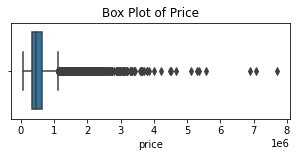

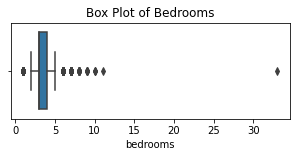

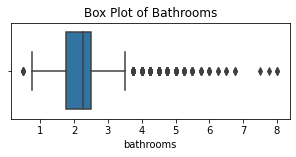

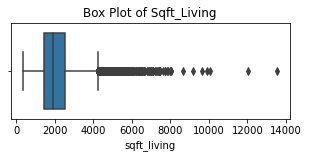

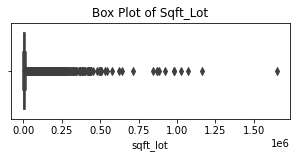

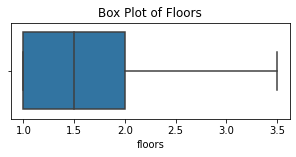

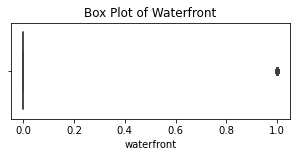

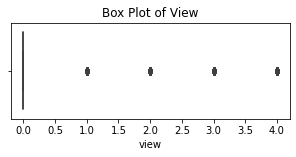

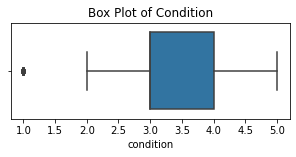

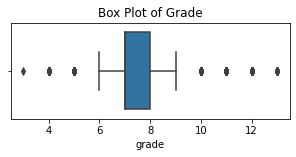

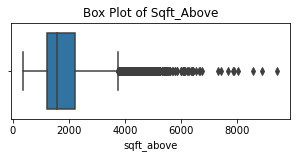

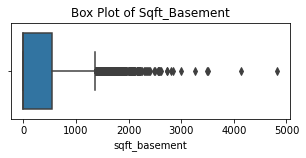

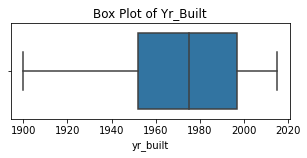

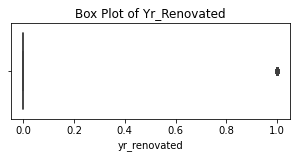

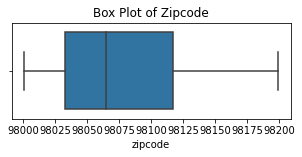

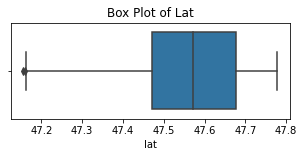

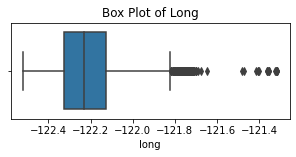

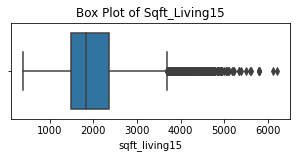

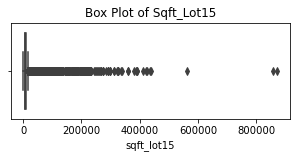

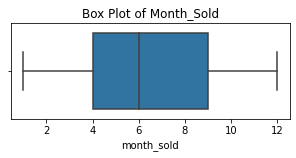

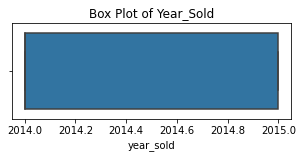

In [26]:
for col in df:
    plot_boxplots(df =df , col=col)

In [27]:
# Remove outliers using IQR method
# Code modified from https://stackoverflow.com/questions/50461349/how-to-remove-outlier-from-dataframe-using-iqr
def outlier_IQR(df):
    
    keep = df.describe()
    q1 = keep['25%']
    q3 = keep['75%']
    IQR = q3-q1
    outliers =(df < (q1- 1.5 * IQR)) | (df > (q3 + 1.5 * IQR))
    return outliers

In [28]:
# Create list of columns to remove outliers from
outliers_col = ['price','bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'sqft_above',
                'sqft_basement', 'sqft_living15', 'sqft_lot15']
df1 = df.copy()

# Remove outliers for specified columns
for col in outliers_col:
    df1 = df1[~outlier_IQR(df1[col])]

In [29]:
df1

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month_sold,year_sold
0,"221,900.00000",3,1.00000,1180,5650,1.00000,0.00000,0.00000,3,7,1180,0.00000,1955,0.00000,98178,47.51120,-122.25700,1340,5650,10,2014
1,"538,000.00000",3,2.25000,2570,7242,2.00000,0.00000,0.00000,3,7,2170,400.00000,1951,1.00000,98125,47.72100,-122.31900,1690,7639,12,2014
2,"180,000.00000",2,1.00000,770,10000,1.00000,0.00000,0.00000,3,6,770,0.00000,1933,0.00000,98028,47.73790,-122.23300,2720,8062,2,2015
3,"604,000.00000",4,3.00000,1960,5000,1.00000,0.00000,0.00000,5,7,1050,910.00000,1965,0.00000,98136,47.52080,-122.39300,1360,5000,12,2014
4,"510,000.00000",3,2.00000,1680,8080,1.00000,0.00000,0.00000,3,8,1680,0.00000,1987,0.00000,98074,47.61680,-122.04500,1800,7503,2,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,"360,000.00000",3,2.50000,1530,1131,3.00000,0.00000,0.00000,3,8,1530,0.00000,2009,0.00000,98103,47.69930,-122.34600,1530,1509,5,2014
21593,"400,000.00000",4,2.50000,2310,5813,2.00000,0.00000,0.00000,3,8,2310,0.00000,2014,0.00000,98146,47.51070,-122.36200,1830,7200,2,2015
21594,"402,101.00000",2,0.75000,1020,1350,2.00000,0.00000,0.00000,3,7,1020,0.00000,2009,0.00000,98144,47.59440,-122.29900,1020,2007,6,2014
21595,"400,000.00000",3,2.50000,1600,2388,2.00000,0.00000,0.00000,3,8,1600,0.00000,2004,0.00000,98027,47.53450,-122.06900,1410,1287,1,2015


In [30]:
# Drop price to only show correlation between independent variables
corr = df1.drop('price', axis=1).corr().round(2)

In [31]:
# Create mask for upper triangle of matrix
mask = np.zeros_like(corr)

mask[np.triu_indices_from(mask)] = True

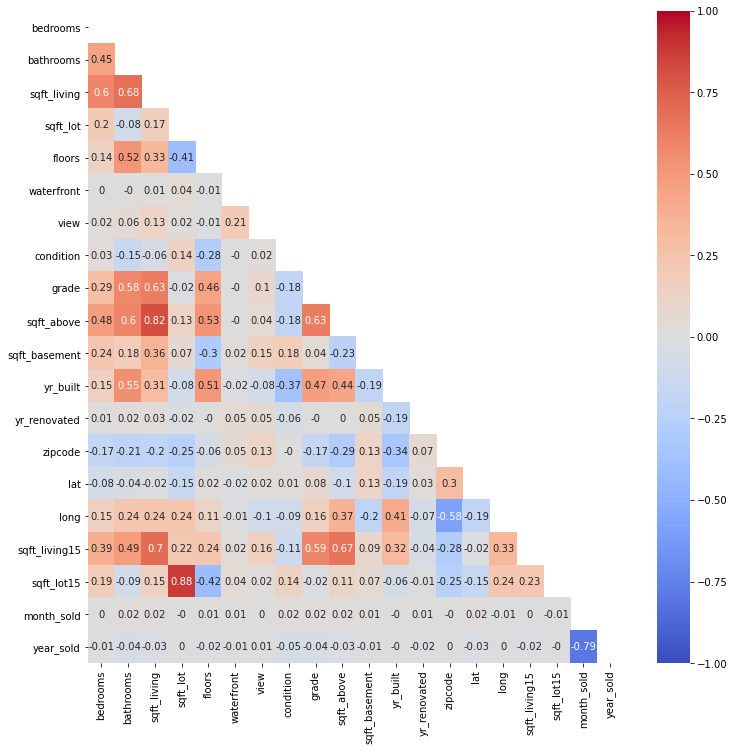

In [32]:
# Create heatmap correlation matrix
# https://medium.com/@chrisshaw982/seaborn-correlation-heatmaps-customized-10246f4f7f4b
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(corr, annot=True, ax=ax, cmap='coolwarm', vmin=-1, vmax=1,mask=mask);

### Exploratory Data Analysis (EDA)

### Question 1: waterfront

In [33]:
print(len(df1[df1['waterfront'] == 1]))

14


In [34]:
len(df1[df1['waterfront'] == 1]) / len(df)

0.00065359477124183

Text(0.5, 0, 'Longitude')

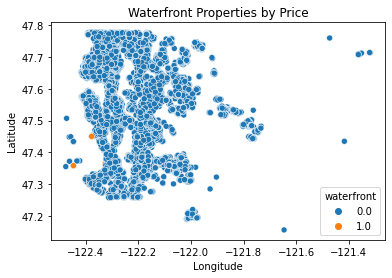

In [35]:

sns.scatterplot(x= 'long', y= 'lat', hue= 'waterfront', data= df1, 
                palette= 'tab10')
plt.title('Waterfront Properties by Price')
plt.ylabel('Latitude')
plt.xlabel('Longitude')

In [36]:
df1.groupby('waterfront')['price'].mean().round(2)

waterfront
0.00000   448,608.91000
1.00000   794,496.43000
Name: price, dtype: float64

''

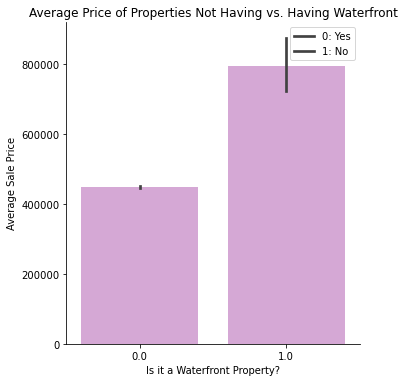

In [37]:
labels = ['0: Yes', '1: No']
sns.catplot(x="waterfront", y="price", kind="bar", data=df1, color= 'plum')
plt.title('Average Price of Properties Not Having vs. Having Waterfront')
plt.xlabel('Is it a Waterfront Property?')
plt.ylabel('Average Sale Price')
plt.legend(labels= labels)
;

In [38]:
df1_w = df1.groupby('waterfront')['price'].mean().round(2)
df1_w

waterfront
0.00000   448,608.91000
1.00000   794,496.43000
Name: price, dtype: float64

Placeholder
Getting a house on the water is possible, but there are not a lot of them out there. Plus, if the first time home buyer does want that feature, they'll have to pay!

Waterfront: A house or property on the water will run the buyer an extra \$143,636 more than a house that is inland.

### Question 2: View

Text(0.5, 0, 'View')

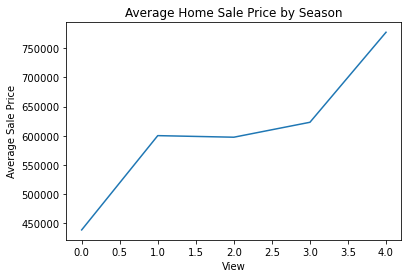

In [39]:
plt.plot(df1.groupby('view')['price'].mean().round(2))
plt.title('Average Home Sale Price by Season')
plt.ylabel('Average Sale Price')
plt.xlabel('View')

Text(0.5, 0, 'View')

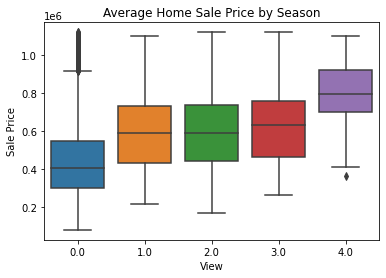

In [40]:
sns.boxplot(x= 'view', y= 'price', data= df1)
plt.title('Average Home Sale Price by Season')
plt.ylabel('Sale Price')
plt.xlabel('View')

In [41]:
df1_v = df1.groupby('view')['price'].mean().round(2)
df1_v

view
0.00000   438,366.25000
1.00000   600,102.21000
2.00000   597,394.67000
3.00000   623,018.55000
4.00000   777,460.35000
Name: price, dtype: float64

Placeholder - Whoa! It can really pay off to have your house advertised and have a lot of people look at it. There is an average increase of \$201,741 from houses that were not viewed, to houses that received the most views.

### Question 3 grade

In [42]:
df1_g = df1.groupby('grade')['price'].mean().round(2)
df1_g

grade
4    206,300.00000
5    237,756.98000
6    301,786.80000
7    398,414.18000
8    513,926.15000
9    663,705.36000
10   776,254.30000
11   904,000.00000
Name: price, dtype: float64

''

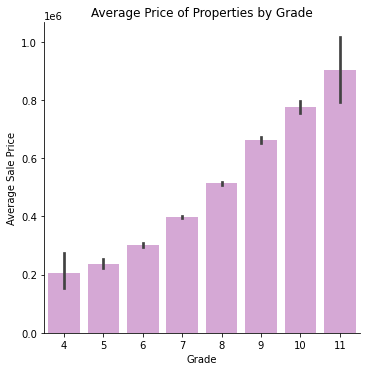

In [43]:
sns.catplot(x="grade", y="price", kind="bar", data=df1, color= 'plum')
plt.title('Average Price of Properties by Grade')
plt.xlabel('Grade')
plt.ylabel('Average Sale Price')
;

after removing outliers, mention q-q, r2, homoscedasticity

## Model 1 (Everything)

In [44]:
X = df1.drop('price', axis= 1)
y = df1['price']

In [45]:
model_summary(df1)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.675
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                     1671.
Date:                Wed, 30 Jun 2021   Prob (F-statistic):               0.00
Time:                        02:06:19   Log-Likelihood:            -2.0950e+05
No. Observations:               16110   AIC:                         4.190e+05
Df Residuals:                   16089   BIC:                         4.192e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -4.392e+07   6.21e+06     -7.071      0.000   -5.61e+07   -3.17e+07
bedrooms      -1.002e+04   1435.872     -6.979      0.000   -1.28e+04   -7206.667
bathrooms      1.858e+04   2210.142      8.405      0.000    1.42e+04    2.29e+04
sqft_living      81.0034     13.565      5.972      0.000      54.415     107.592
sqft_lot         -2.4121      0.566     -4.264      0.000      -3.521      -1.303
floors         9270.5716   2567.871      3.610      0.000    4237.257    1.43e+04
waterfront     2.596e+05   2.95e+04      8.789      0.000    2.02e+05    3.17e+05
view           3.244e+04   1693.060     19.161      0.000    2.91e+04    3.58e+04
condition      2.748e+04   1465.286     18.755      0.000    2.46e+04    3.04e+04
grade          7.763e+04   1479.043     52.486      0.000    7.47e+04    8.05e+04
sqft_above       12.1730     13.542      0.899      0.369     -14.371      38.717
sqft_basement     5.5521     13.419      0.414      0.679     -20.750      31.854
yr_built      -1936.5414     45.239    -42.807      0.000   -2025.214   -1847.869
yr_renovated   3.483e+04   5358.887      6.499      0.000    2.43e+04    4.53e+04
zipcode        -266.6844     20.724    -12.868      0.000    -307.306    -226.063
lat            5.406e+05   6668.358     81.072      0.000    5.28e+05    5.54e+05
long          -1.787e+04   8780.910     -2.035      0.042   -3.51e+04    -656.170
sqft_living15    46.2893      2.719     17.027      0.000      40.961      51.618
sqft_lot15       -6.6520      0.645    -10.306      0.000      -7.917      -5.387
month_sold      190.6173    439.628      0.434      0.665    -671.103    1052.338
year_sold      2.262e+04   2932.618      7.714      0.000    1.69e+04    2.84e+04
==============================================================================
Omnibus:                     1652.406   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3342.605
Skew:                           0.666   Prob(JB):                         0.00
Kurtosis:                       4.791   Cond. No.                     7.23e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.23e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

Train RMSE: 107763.00645297304
Test RMSE: 106580.99629475706
Train R2: 0.6758137450406583
Test R2: 0.6707902376594655


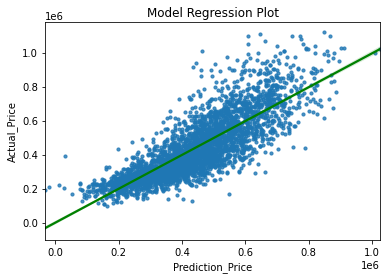

In [47]:
linear_model(X_train,y_train,X_test,y_test)

## Model 2
This model I understanding as being a model that captures 'What' the home is. It represents elements that define the property itself: size (square footage and number of bedrooms), age, and quality (grade, waterfront).

In [48]:
df2 = df1.drop(['floors','waterfront','view','condition','grade','yr_renovated',
                'zipcode','lat','long','month_sold','year_sold'], 
               axis =1)
df2

,price,bedrooms,bathrooms,sqft_living,sqft_lot,sqft_above,sqft_basement,yr_built,sqft_living15,sqft_lot15
0,"221,900.00000",3,1.00000,1180,5650,1180,0.00000,1955,1340,5650
1,"538,000.00000",3,2.25000,2570,7242,2170,400.00000,1951,1690,7639
2,"180,000.00000",2,1.00000,770,10000,770,0.00000,1933,2720,8062
3,"604,000.00000",4,3.00000,1960,5000,1050,910.00000,1965,1360,5000
4,"510,000.00000",3,2.00000,1680,8080,1680,0.00000,1987,1800,7503
...,...,...,...,...,...,...,...,...,...,...
21592,"360,000.00000",3,2.50000,1530,1131,1530,0.00000,2009,1530,1509
21593,"400,000.00000",4,2.50000,2310,5813,2310,0.00000,2014,1830,7200
21594,"402,101.00000",2,0.75000,1020,1350,1020,0.00000,2009,1020,2007
21595,"400,000.00000",3,2.50000,1600,2388,1600,0.00000,2004,1410,1287


In [49]:
model_summary(df2)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.426
Method:                 Least Squares   F-statistic:                     1329.
Date:                Wed, 30 Jun 2021   Prob (F-statistic):               0.00
Time:                        02:06:19   Log-Likelihood:            -2.1408e+05
No. Observations:               16110   AIC:                         4.282e+05
Df Residuals:                   16100   BIC:                         4.282e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       4.68e+06   9.38e+04     49.910      0.000     4.5e+06    4.86e+06
bedrooms      -2.922e+04   1881.742    -15.531      0.000   -3.29e+04   -2.55e+04
bathrooms      4.337e+04   2806.158     15.457      0.000    3.79e+04    4.89e+04
sqft_living     141.9940     17.946      7.912      0.000     106.817     177.171
sqft_lot         -5.9602      0.741     -8.047      0.000      -7.412      -4.508
sqft_above        4.0154     17.808      0.225      0.822     -30.890      38.921
sqft_basement     1.1195     17.818      0.063      0.950     -33.806      36.045
yr_built      -2317.3265     48.698    -47.585      0.000   -2412.781   -2221.872
sqft_living15   100.4607      3.401     29.536      0.000      93.794     107.128
sqft_lot15       -8.8162      0.841    -10.481      0.000     -10.465      -7.167
==============================================================================
Omnibus:                      827.073   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1028.550
Skew:                           0.527   Prob(JB):                    4.50e-224
Kurtosis:                       3.649   Cond. No.                     9.18e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.18e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [50]:
X = df2.drop(['price','sqft_above','sqft_basement'], axis= 1)
y = df2['price']

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

Train RMSE: 143045.80906630988
Test RMSE: 142065.32007480858
Train R2: 0.42877727591616877
Test R2: 0.4150896553622577


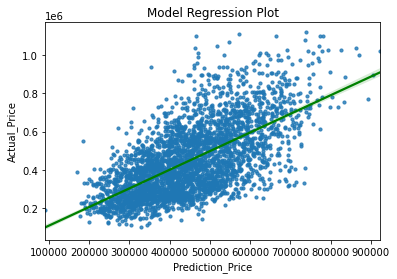

In [52]:
linear_model(X_train,y_train,X_test,y_test)

## Model 3
We can see that there are some categorical variables in our dataset, but other than the 'zipcode' column, the other variables are ordinal.

We will proceed to use One Hot Encoding prior to running our multiple regression model including the zipcode data.

In [53]:
# One Hot Encode zipcodes column
encoder = OneHotEncoder(drop='first',sparse=False)
encoder.fit(df1[['zipcode']])

ohe_vars = encoder.transform(df1[['zipcode']])

df1_ohe = pd.DataFrame(ohe_vars,columns=encoder.get_feature_names(['zipcode']),
                      index=df1.index)
df1_ohe

,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000
1,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [54]:
# Join One Hot Encoded dataframe with original dataframe and drop
# original zipcodes column
df3 = pd.concat([df1.drop('zipcode',axis=1),df1_ohe],axis=1)
df3

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,month_sold,year_sold,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,"221,900.00000",3,1.00000,1180,5650,1.00000,0.00000,0.00000,3,7,1180,0.00000,1955,0.00000,47.51120,-122.25700,1340,5650,10,2014,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000
1,"538,000.00000",3,2.25000,2570,7242,2.00000,0.00000,0.00000,3,7,2170,400.00000,1951,1.00000,47.72100,-122.31900,1690,7639,12,2014,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,"180,000.00000",2,1.00000,770,10000,1.00000,0.00000,0.00000,3,6,770,0.00000,1933,0.00000,47.73790,-122.23300,2720,8062,2,2015,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,"604,000.00000",4,3.00000,1960,5000,1.00000,0.00000,0.00000,5,7,1050,910.00000,1965,0.00000,47.52080,-122.39300,1360,5000,12,2014,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,"510,000.00000",3,2.00000,1680,8080,1.00000,0.00000,0.00000,3,8,1680,0.00000,1987,0.00000,47.61680,-122.04500,1800

In [55]:
X = df3.drop('price', axis= 1)
y = df3['price']

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

Train RMSE: 77563.77746126958
Test RMSE: 77421.78462087302
Train R2: 0.832052670567212
Test R2: 0.8262841243835737


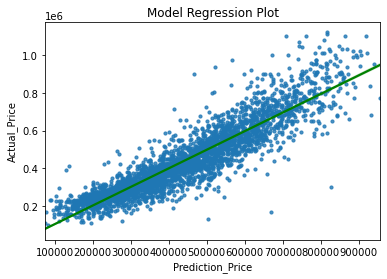

In [57]:
linear_model(X_train,y_train,X_test,y_test)

In [58]:
model_summary(df3)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     896.9
Date:                Wed, 30 Jun 2021   Prob (F-statistic):               0.00
Time:                        02:06:21   Log-Likelihood:            -2.0422e+05
No. Observations:               16110   AIC:                         4.086e+05
Df Residuals:                   16021   BIC:                         4.093e+05
Df Model:                          88                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -5.693e+07   6.09e+06     -9.341      0.000   -6.89e+07    -4.5e+07
bedrooms      -3036.8663   1052.083     -2.887      0.004   -5099.066    -974.666
bathrooms      1.409e+04   1605.149      8.778      0.000    1.09e+04    1.72e+04
sqft_living      67.4676      9.822      6.869      0.000      48.215      86.720
sqft_lot          1.4553      0.412      3.535      0.000       0.648       2.262
floors        -1.436e+04   1935.547     -7.418      0.000   -1.82e+04   -1.06e+04
waterfront     2.824e+05   2.15e+04     13.109      0.000     2.4e+05    3.25e+05
view           3.286e+04   1247.803     26.336      0.000    3.04e+04    3.53e+04
condition       2.47e+04   1086.616     22.727      0.000    2.26e+04    2.68e+04
grade          4.192e+04   1147.685     36.529      0.000    3.97e+04    4.42e+04
sqft_above       56.1582      9.821      5.718      0.000      36.907      75.409
sqft_basement     9.0760      9.712      0.935      0.350      -9.960      28.112
yr_built       -520.6997     37.163    -14.011      0.000    -593.543    -447.856
yr_renovated   3.655e+04   3890.933      9.393      0.000    2.89e+04    4.42e+04
lat           -2.045e+04   3.97e+04     -0.515      0.606   -9.82e+04    5.73e+04
long          -2.812e+04   3.28e+04     -0.859      0.391   -9.23e+04    3.61e+04
sqft_living15    27.2929      2.047     13.334      0.000      23.281      31.305
sqft_lot15        0.0251      0.498      0.050      0.960      -0.950       1.001
month_sold      592.5210    318.088      1.863      0.063     -30.968    1216.010
year_sold      2.735e+04   2122.928     12.882      0.000    2.32e+04    3.15e+04
zipcode_98002  1.103e+04   7760.172      1.422      0.155   -4177.266    2.62e+04
zipcode_98003  -574.0697   7074.272     -0.081      0.935   -1.44e+04    1.33e+04
zipcode_98004  5.247e+05    1.5e+04     34.911      0.000    4.95e+05    5.54e+05
zipcode_98005  3.351e+05   1.55e+04     21.660      0.000    3.05e+05    3.65e+05
zipcode_98006  2.708e+05   1.28e+04     21.186      0.000    2.46e+05    2.96e+05
zipcode_98007  2.588e+05   1.55e+04     16.654      0.000    2.28e+05    2.89e+05
zipcode_98008  2.428e+05   1.51e+04     16.096      0.000    2.13e+05    2.72e+05
zipcode_98010  6.504e+04    1.6e+04      4.075      0.000    3.38e+04    9.63e+04
zipcode_98011  1.557e+05   1.95e+04      7.973      0.000    1.17e+05    1.94e+05
zipcode_98014  1.352e+05   2.85e+04      4.746      0.000    7.94e+04    1.91e+05
zipcode_98019  1.076e+05   2.17e+04      4.954      0.000     6.5e+04     1.5e+05
zipcode_98022  6332.5886   1.27e+04      0.498      0.619   -1.86e+04    3.13e+04
zipcode_98023 -1.841e+04   6895.861     -2.669      0.008   -3.19e+04   -4891.632
zipcode_98024  1.628e+05   2.41e+04      6.742      0.000    1.15e+05     2.1e+05
zipcode_98027  2.403e+05   1.39e+04     17.351   

result placeholder

## Model 4

In [59]:
df4 = df3.drop(['floors','waterfront','view','condition','grade','yr_renovated',
                'lat','long','month_sold','year_sold'],
               axis =1)
df4

,price,bedrooms,bathrooms,sqft_living,sqft_lot,sqft_above,sqft_basement,yr_built,sqft_living15,sqft_lot15,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,"221,900.00000",3,1.00000,1180,5650,1180,0.00000,1955,1340,5650,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000
1,"538,000.00000",3,2.25000,2570,7242,2170,400.00000,1951,1690,7639,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,"180,000.00000",2,1.00000,770,10000,770,0.00000,1933,2720,8062,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,"604,000.00000",4,3.00000,1960,5000,1050,910.00000,1965,1360,5000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,"510,000.00000",3,2.00000,1680,8080,1680,0.00000,1987,1800,7503,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0

In [60]:
X = df4.drop('price', axis= 1)
y = df4['price']

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

Train RMSE: 85874.97180822772
Test RMSE: 83815.85255107211
Train R2: 0.7941322044407324
Test R2: 0.7964057596072069


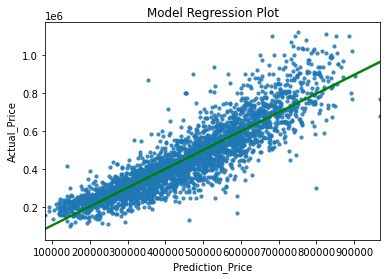

In [62]:
linear_model(X_train,y_train,X_test,y_test)

In [64]:
model_summary(df4)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     796.4
Date:                Wed, 30 Jun 2021   Prob (F-statistic):               0.00
Time:                        02:08:36   Log-Likelihood:            -2.0579e+05
No. Observations:               16110   AIC:                         4.117e+05
Df Residuals:                   16031   BIC:                         4.123e+05
Df Model:                          78                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      9.016e+05   6.74e+04     13.373      0.000    7.69e+05    1.03e+06
bedrooms      -8418.2326   1151.496     -7.311      0.000   -1.07e+04   -6161.171
bathrooms      2.138e+04   1700.785     12.570      0.000     1.8e+04    2.47e+04
sqft_living      95.0841     10.789      8.813      0.000      73.936     116.232
sqft_lot          1.9029      0.451      4.218      0.000       1.019       2.787
sqft_above       50.5092     10.708      4.717      0.000      29.520      71.498
sqft_basement     7.1327     10.701      0.667      0.505     -13.843      28.109
yr_built       -520.2424     33.997    -15.303      0.000    -586.879    -453.605
sqft_living15    49.2975      2.161     22.812      0.000      45.062      53.533
sqft_lot15        1.9207      0.543      3.538      0.000       0.857       2.985
zipcode_98002  1.746e+04   8298.278      2.103      0.035    1189.795    3.37e+04
zipcode_98003  1.462e+04   7650.201      1.910      0.056    -380.181    2.96e+04
zipcode_98004  5.308e+05   9656.768     54.965      0.000    5.12e+05     5.5e+05
zipcode_98005  3.464e+05   1.05e+04     32.986      0.000    3.26e+05    3.67e+05
zipcode_98006  2.914e+05   7498.397     38.867      0.000    2.77e+05    3.06e+05
zipcode_98007  2.733e+05   9617.096     28.422      0.000    2.54e+05    2.92e+05
zipcode_98008  2.569e+05   7739.527     33.193      0.000    2.42e+05    2.72e+05
zipcode_98010  5.198e+04   1.49e+04      3.494      0.000    2.28e+04    8.11e+04
zipcode_98011  1.454e+05   8656.037     16.800      0.000    1.28e+05    1.62e+05
zipcode_98014  1.084e+05    1.9e+04      5.696      0.000    7.11e+04    1.46e+05
zipcode_98019  7.479e+04   9251.726      8.084      0.000    5.67e+04    9.29e+04
zipcode_98022  1.978e+04   8972.908      2.205      0.027    2194.145    3.74e+04
zipcode_98023 -3430.6586   6767.822     -0.507      0.612   -1.67e+04    9835.030
zipcode_98024  1.355e+05   1.99e+04      6.804      0.000    9.64e+04    1.75e+05
zipcode_98027  2.429e+05   8017.832     30.299      0.000    2.27e+05    2.59e+05
zipcode_98028  1.345e+05   7780.875     17.292      0.000    1.19e+05     1.5e+05
zipcode_98029  2.532e+05   7508.226     33.729      0.000    2.39e+05    2.68e+05
zipcode_98030  7922.5398   7743.070      1.023      0.306   -7254.745    2.31e+04
zipcode_98031  1.854e+04   7655.635      2.422      0.015    3538.595    3.36e+04
zipcode_98032   1.75e+04   9939.198      1.760      0.078   -1986.234     3.7e+04
zipcode_98033   3.28e+05   7247.092     45.262      0.000    3.14e+05    3.42e+05
zipcode_98034  1.935e+05   6614.913     29.246      0.000     1.8e+05    2.06e+05
zipcode_98038   3.14e+04   6680.294      4.701      0.000    1.83e+04    4.45e+04
zipcode_98039  6.521e+05   3.87e+04     16.857      0.000    5.76e+05    7.28e+05
zipcode_98040  4.439e+05   9836.041     45.128   

## Model 5

In [63]:
df5 = df3.drop(['floors','bedrooms','waterfront','view','condition','grade','yr_renovated',
                'lat','long','month_sold','year_sold'],
               axis =1)
df5

,price,bathrooms,sqft_living,sqft_lot,sqft_above,sqft_basement,yr_built,sqft_living15,sqft_lot15,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,"221,900.00000",1.00000,1180,5650,1180,0.00000,1955,1340,5650,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000
1,"538,000.00000",2.25000,2570,7242,2170,400.00000,1951,1690,7639,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,"180,000.00000",1.00000,770,10000,770,0.00000,1933,2720,8062,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,"604,000.00000",3.00000,1960,5000,1050,910.00000,1965,1360,5000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,"510,000.00000",2.00000,1680,8080,1680,0.00000,1987,1800,7503,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000

In [68]:
X = df5.drop('price', axis= 1)
y = df5['price']

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

Train RMSE: 86033.0969649213
Test RMSE: 83890.45701222865
Train R2: 0.7933733605720628
Test R2: 0.7960431599791997


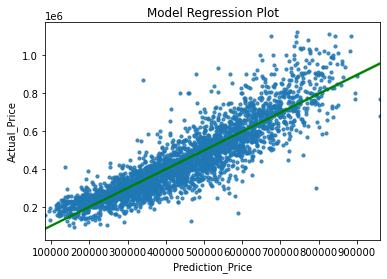

In [70]:
linear_model(X_train,y_train,X_test,y_test)

In [72]:
model_summary(df5)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     803.4
Date:                Wed, 30 Jun 2021   Prob (F-statistic):               0.00
Time:                        02:09:39   Log-Likelihood:            -2.0582e+05
No. Observations:               16110   AIC:                         4.118e+05
Df Residuals:                   16032   BIC:                         4.124e+05
Df Model:                          77                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      8.309e+05   6.68e+04     12.433      0.000       7e+05    9.62e+05
bathrooms      1.956e+04   1685.157     11.604      0.000    1.63e+04    2.29e+04
sqft_living      87.1019     10.751      8.101      0.000      66.028     108.176
sqft_lot          1.8392      0.452      4.071      0.000       0.954       2.725
sqft_above       52.4793     10.722      4.895      0.000      31.463      73.496
sqft_basement     8.9897     10.716      0.839      0.402     -12.015      29.994
yr_built       -492.3125     33.836    -14.550      0.000    -558.636    -425.989
sqft_living15    50.4712      2.159     23.381      0.000      46.240      54.702
sqft_lot15        1.8384      0.544      3.381      0.001       0.773       2.904
zipcode_98002  1.797e+04   8311.546      2.162      0.031    1674.115    3.43e+04
zipcode_98003  1.592e+04   7660.627      2.078      0.038     901.500    3.09e+04
zipcode_98004  5.321e+05   9670.907     55.019      0.000    5.13e+05    5.51e+05
zipcode_98005  3.481e+05   1.05e+04     33.102      0.000    3.28e+05    3.69e+05
zipcode_98006  2.925e+05   7509.162     38.957      0.000    2.78e+05    3.07e+05
zipcode_98007  2.732e+05   9632.783     28.357      0.000    2.54e+05    2.92e+05
zipcode_98008  2.561e+05   7751.403     33.039      0.000    2.41e+05    2.71e+05
zipcode_98010  5.326e+04   1.49e+04      3.575      0.000    2.41e+04    8.25e+04
zipcode_98011  1.474e+05   8666.021     17.006      0.000     1.3e+05    1.64e+05
zipcode_98014    1.1e+05   1.91e+04      5.771      0.000    7.26e+04    1.47e+05
zipcode_98019  7.632e+04   9264.479      8.237      0.000    5.82e+04    9.45e+04
zipcode_98022  2.132e+04   8985.097      2.373      0.018    3710.063    3.89e+04
zipcode_98023 -2609.5857   6777.949     -0.385      0.700   -1.59e+04    1.07e+04
zipcode_98024  1.374e+05   1.99e+04      6.889      0.000    9.83e+04    1.76e+05
zipcode_98027  2.451e+05   8025.375     30.543      0.000    2.29e+05    2.61e+05
zipcode_98028  1.362e+05   7790.288     17.484      0.000    1.21e+05    1.51e+05
zipcode_98029  2.552e+05   7515.564     33.961      0.000    2.41e+05     2.7e+05
zipcode_98030  8690.8233   7755.011      1.121      0.262   -6509.866    2.39e+04
zipcode_98031  1.882e+04   7668.056      2.454      0.014    3786.022    3.38e+04
zipcode_98032  1.723e+04   9955.376      1.731      0.084   -2283.185    3.67e+04
zipcode_98033  3.297e+05   7255.062     45.451      0.000    3.16e+05    3.44e+05
zipcode_98034  1.939e+05   6625.471     29.263      0.000    1.81e+05    2.07e+05
zipcode_98038   3.23e+04   6690.074      4.829      0.000    1.92e+04    4.54e+04
zipcode_98039  6.524e+05   3.87e+04     16.838      0.000    5.76e+05    7.28e+05
zipcode_98040  4.455e+05   9849.587     45.231      0.000    4.26e+05    4.65e+05
zipcode_98042  1.693e+04   6767.637      2.501   

## Conclusions Placeholder
This analysis leads to three recommendations for creating movies :

**1. Release movies in May, June, July, November, or December.** Our analysis shows that summertime and holiday seasons are the best time of year to release a movie. If Microsoft wants to release a movie across the world simultaneously, I recommend launching a movie in June or July. If different timeline can be applied, release a movie in the States in May first, then internationally in June.

**2. Produce a movie in Mystery, Horror, Animation genres.** Microsoft has the capability to run movie business in many countries as it has many locations worldwide. Therefore, I recommend producing a movie in Mystery, Horror, and Animation to target audience globally.

**3. Recruit people with proven stats.** I provided lists of top 10 actors and directors in top 3 genres that generated the most profit. Microsoft should contact these individuals and try to recruit them to enter this competitive movie industry

## Next Steps Placeholder
Further analyses could lead to additional insights:
* **ROI Trend in Popular Genres**: while we have identified which top 3 genres have generated the most profit, such analysis can provide whether the business is continuously growing in those genres over time.
* **Ideal Budget Range**: This modeling could predict the ideal production budget for the movies that Microsoft wants to produce.